# Potato Disease Classification with CNN: Pre Trained Model

## 1. Setup the dataset 

In [1]:
import tensorflow as tf

IMG_SIZE = (224, 224)   # MobileNetV2 default
BATCH_SIZE = 32
data = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/potato"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 2965 files belonging to 3 classes.
Using 2372 files for training.
Found 2965 files belonging to 3 classes.
Using 593 files for validation.
Classes: ['Potato___Early_blight', 'Potato___Healthy_Final', 'Potato___Late_blight']


In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)


Found 2965 files belonging to 3 classes.
Using 2372 files for training.


## 2. Preprocess the data

In [3]:
from tensorflow.keras import layers

# Normalize (MobileNet expects [0, 1] scaled inputs)
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)


## 3. Build model with MobileNetV2

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

# Load pretrained base (no top layers)
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base model (so we only train the new top layers)
base_model.trainable = False

# Add new classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Compile the model

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


## 5. Train the model

In [6]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 637ms/step - accuracy: 0.7376 - loss: 0.6008 - val_accuracy: 0.9764 - val_loss: 0.1178
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 592ms/step - accuracy: 0.9500 - loss: 0.1678 - val_accuracy: 0.9848 - val_loss: 0.0767
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 589ms/step - accuracy: 0.9557 - loss: 0.1298 - val_accuracy: 0.9899 - val_loss: 0.0556
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 595ms/step - accuracy: 0.9626 - loss: 0.0971 - val_accuracy: 0.9949 - val_loss: 0.0444
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 598ms/step - accuracy: 0.9697 - loss: 0.0850 - val_accuracy: 0.9916 - val_loss: 0.0412
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 594ms/step - accuracy: 0.9730 - loss: 0.0796 - val_accuracy: 0.9916 - val_loss: 0.0373
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 620ms/step - accuracy: 0.9733 - loss: 0.0666 - val_accuracy: 0.9916 - val_loss: 0.0334
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 610ms/step - accuracy: 0.9792 - loss: 0.0611 - val_accu

## 6. Evaluate the model

In [7]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation accuracy: {val_acc:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 482ms/step - accuracy: 0.9974 - loss: 0.0258 
Validation accuracy: 0.997


## 7. Plot the learning rate

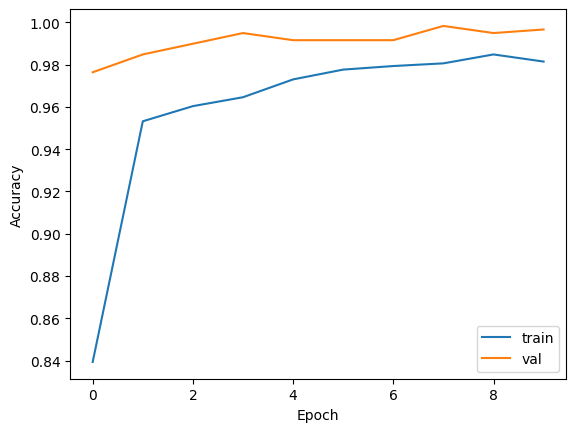

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


## 8. Try fine tunning for higher accuracy

In [9]:
base_model.trainable = True

# But keep lower layers frozen (they detect generic features)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 921ms/step - accuracy: 0.8028 - loss: 0.5048 - val_accuracy: 0.9831 - val_loss: 0.0476
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 882ms/step - accuracy: 0.9507 - loss: 0.1452 - val_accuracy: 0.9781 - val_loss: 0.0623
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 939ms/step - accuracy: 0.9761 - loss: 0.0682 - val_accuracy: 0.9781 - val_loss: 0.0602
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 959ms/step - accuracy: 0.9822 - loss: 0.0484 - val_accuracy: 0.9781 - val_loss: 0.0562
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 73s 969ms/step - accuracy: 0.9908 - loss: 0.0360 - val_accuracy: 0.9848 - val_loss: 0.0464
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 74s 981ms/step - accuracy: 0.9903 - loss: 0.0334 - val_accuracy: 0.9848 - val_loss: 0.0416
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 74s 979ms/step - accuracy: 0.9862 - loss: 0.0352 - val_accuracy: 0.9848 - val_loss: 0.0366
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 888ms/step - accuracy: 0.9913 - loss: 0.0281 - val_accu

## 9. Save the model 

In [10]:
model.save("potato_classifier_pretrained.h5")

## 10. Prediction

In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/potato/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) / 255.0  # normalize

pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]
print(f"Predicted class: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Potato___Early_blight


## Conclusion
1. Without pretrained model, the accuracy model is around 0.90. The training and validation accuracy almost similar.
2. With pretrained  model, accuracy becomes 0.99. The training and validation accuracy almost similar.
3. The next challenge is by using all the data available: pepper, tomatoes and potatoe then use classification to predict whether the leaves healthy or infected by disease.